# Part 1: Initial Gene Expression Heatmap in Patients with Pancreatic Cancer

1. Using the two CSV files (datasets/Sophia_PAAD_RNAseq.csv and datasets/Sophia_PAAD_patients.csv), we're looking to create a heatmap of genes of interest with expression in patients.

First step is to remove patients with neuroendocrine and unknown histologies. The selection to be removed has been listed in datasets/paad_tcga_clinical_data.tsv. 

Comments are noted in python with #.

In [1]:
# importing data analysis libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# for debugging
import pixiedust

Pixiedust database opened successfully


In [3]:
# for reloading libraries and making sure charts and images are displayed
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
def remove_patients_from_list(to_remove_file):
    # importing the PAAD patients file (datasets/Sophia_PAAD_patients.csv) as a table in pandas 
    all_paad_patients = pd.read_csv('datasets/Sophia_PAAD_patients.csv', delimiter = ',')
    # importing the patients to be removed (datasets/paad_tcga_clinical_data.csv), only importing
    # the patient ids
    to_remove_list = pd.read_csv(to_remove_file, delimiter = '\t')["Patient ID"]
    # removing patients
    paad_patients = all_paad_patients[~all_paad_patients.submitter_id.isin(to_remove_list)]
    
    return paad_patients

paad_patients = remove_patients_from_list('datasets/paad_tcga_clinical_data.tsv')

paad_patients
# testing to see if the patients were removed, the table should be empty
# paad_patients[paad_patients.submitter_id == 'TCGA-2L-AAQM']

,Cancer_type,submitter_id,PNI,LVI,Extensive PNI,Filename,Diagnosis Age,Sex,Race Category,American Joint Committee on Cancer Tumor Stage Code,Disease Free (Months),Disease Free Status,Neoplasm Disease Stage American Joint Committee on Cancer Code,Neoplasm Histologic Grade,Overall Survival (Months),Overall Survival Status
0,PAAD,TCGA-2J-AAB1,-,1,NaN,caf9cab4-f98f-46bd-a75d-0eb1e9c6c9ea.htseq.cou...,65,Male,WHITE,T3,NaN,NaN,Stage IIB,G3,2.17,DECEASED
1,PAAD,TCGA-2J-AAB4,1,0,1.0,057aa9ac-f22c-4c11-a44d-ad52ae59b4cf.htseq.cou...,48,Male,WHITE,T2,23.95,DiseaseFree,Stage IIB,G2,23.95,LIVING
2,PAAD,TCGA-2J-AAB8,1,1,NaN,03094067-02d4-40c5-b6fa-bb5180dc7eab.htseq.cou...,71,Male,WHITE,T3,2.63,DiseaseFree,Stage IIB,G3,2.63,LIVING
3,PAAD,TCGA-2J-AAB9,1,-,NaN,c19f102d-47a0-48c6-9443-63730d9ea6d1.htseq.cou...,70,Female,WHITE,T3,17.12,Recurred/Progressed,Stage IIB,G1,20.60,DECEASED
4,PAAD,TCGA-2J-AABA,0,0,NaN,c4cadcbb-ae87-43a5-811c-6bedda1d1d8d.htseq.cou...,55,Male,WHITE,T3,15.51,Recurred/Progressed,Stage IIB,G2,19.94,DECEASED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,PAAD,TCGA-S4-A8RP,1,1,NaN,464c3bd5-5bd2-415f-919e-a5a779a103c4.htseq.cou...,77,Female,WHITE,T3,NaN,NaN,Stage IIB,G3,23.06,DECEASED
150,PAAD,TCGA-US-A779,0,0,NaN,65f1f44c-1f60-45cd-8e1d-16304536c4d5.htseq.cou...,54,Female,WHITE,T3,NaN,NaN,Stage IIB,G1,16.79,DECEASED
151,PAAD,TCGA-XD-AAUG,1,1,1.0,30de5f0b-3c3e-4120-b2bd-9204214341fc.htseq.cou...,66,Female,WHITE,T3,13.80,DiseaseFree,Stage IV,G2,13.80,LIVING
152,PAAD,TCGA-XN-A8T3,1,1,NaN,4cd85f4f-162e-40a8-ab1d-4f6f562c68ff.htseq.cou...,67,Male,WHITE,T2,31.24,DiseaseFree,Stage IB,G2,31.24,LIVING


Once the patient table is edited, the RNA seq table can be edited to focus on the neurotransmitter families and the genes that correspond to each of these families.

Actually, we're going to instead filter the patients directly to get desired columns

In [5]:
all_rnaseq = pd.read_csv('datasets/Sophia_PAAD_RNAseq.csv', delimiter = ',')

neurotransmitter_genes = pd.read_csv('datasets/neurotransmitter_gene_family.csv', delimiter = ',')

def filter_genes_of_interest(table):
    # take the RNASeq data table to only include genes of interest
    rnaseq_goi = table[table['hgnc_symbol'].isin(neurotransmitter_genes["receptor gene"])]
    return rnaseq_goi

In [6]:
def create_counts_list():
    # taking only the counts from paad patients
    # rnaseq = rnaseq_goi[rnaseq_goi.columns.intersection(count_files_list)]
    count_files_table = pd.read_csv('datasets/Sophia_TCGA_to_exclude.csv')
    count_files = count_files_table[count_files_table.columns[1]].tolist()
    

    count_files_list = []
    # the filenames column is formatted differently from the column names in the RNASeq table
    for file in count_files:
        remove_dash = file.replace('-', '.')
        remove_tab = remove_dash.replace('\t', '')
        count_files_list.append(remove_tab)
        
    
    
    return count_files_list

In [30]:
receptor_gene_list = neurotransmitter_genes['receptor gene'].tolist()

def sort_genes_of_interest(table):
    table.loc[:, 'hgnc_symbol'] = pd.Categorical(rnaseq['hgnc_symbol'], categories = receptor_gene_list, ordered = True)
    table = table.sort_values('hgnc_symbol')
    return table

In [7]:
# might come back to deal with this warning? it gets the result for now
pd.options.mode.chained_assignment = None

In [31]:
rnaseq_goi = filter_genes_of_interest(all_rnaseq)

count_files = create_counts_list()

rnaseq = rnaseq_goi[rnaseq_goi.columns.difference(count_files)]
rnaseq.drop('Unnamed: 0', axis=1, inplace=True)

# sorting the returned table so it's in the same order as neurotransmitter_gene_family.csv
rnaseq = sort_genes_of_interest(rnaseq)

first_column = rnaseq['hgnc_symbol']
rnaseq.drop(labels=['hgnc_symbol'], axis=1, inplace=True)
rnaseq.insert(0, 'hgnc_symbol', first_column)

# later when we calculate tpm we need a dataframe of all of the genes but only the samples we want
all_rnaseq_selected_samples = all_rnaseq[all_rnaseq.columns.difference(count_files)]
all_rnaseq_selected_samples.drop('Unnamed: 0', axis=1, inplace=True)
first_column = all_rnaseq_selected_samples['hgnc_symbol']
all_rnaseq_selected_samples.drop(labels=['hgnc_symbol'], axis=1, inplace=True)
all_rnaseq_selected_samples.insert(0, 'hgnc_symbol', first_column)

rnaseq


,hgnc_symbol,X00faf8ba.ff90.4214.9d03.6c5e14645d8f.htseq.counts.gz,X0143419f.2abe.4906.bb55.af6010fab05f.htseq.counts.gz,X01f84c45.2058.4e22.b234.52f0a82a97fc.htseq.counts.gz,X03094067.02d4.40c5.b6fa.bb5180dc7eab.htseq.counts.gz,X0349f526.7816.4a7d.9967.1f75dd9ff00a.htseq.counts.gz,X03630a0c.aa97.4e28.bac9.0206fff669cd.htseq.counts.gz,X03761959.a620.440f.bbaa.33bd75afae1c.htseq.counts.gz,X057aa9ac.f22c.4c11.a44d.ad52ae59b4cf.htseq.counts.gz,X05f0ced5.6976.4f43.9be5.fddb3f550adf.htseq.counts.gz,...,eb3894d4.fcae.43ef.ad68.b756c6aa56ea.htseq.counts.gz,f144de50.6126.4912.9c94.824d1eb0fac5.htseq.counts.gz,f2389819.b8fc.460e.821c.01dba313cce1.htseq.counts.gz,f6bd7191.a820.4d86.927a.b4b5f88ebd67.htseq.counts.gz,f748bf78.4dc1.47ad.8611.8186479d3e4b.htseq.counts.gz,f8551a29.d4bd.4954.bf9c.8e10265063de.htseq.counts.gz,f9f63982.b0ee.4cb8.8de5.f885d82137f0.htseq.counts.gz,fcd43085.7338.43fe.bc25.9d87b04e227f.htseq.counts.gz,feb22766.4282.47c8.bfe2.7d020b4a15d4.htseq.counts.gz,fef65b57.c58d.4050.8de4.f09f5cd616ce.htseq.counts.gz
6402,DRD1,147,280,160,116,80,78,514,141,264,...,48,173,99,75,239,78,72,127,115,113
6403,DRD2,4112,2811,17294,3172,13653,5470,3053,15737,5267,...,10159,2557,8638,8886,9238,14085,6181,9665,1771,3394
6404,DRD3,1187,1428,1939,833,1555,1072,1037,2285,1689,...,1475,1105,1357,1286,1366,1016,795,2165,1472,1364
6405,DRD4,2,79,83,39,189,79,6,74,82,...,129,28,126,96,102,84,38,85,73,153
6406,DRD5,357,237,300,206,258,196,81,335,336,...,376,246,158,220,485,249,333,498,390,246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4266,CHRM1,5685,7649,8086,3273,5948,3631,4643,7445,6605,...,6696,3255,5759,5961,6380,6388,4604,6820,6240,4534
4267,CHRM2,2511,7302,24450,2328,6852,2250,4499,6888,6787,...,4054,2257,4812,4628,6258,6866,3075,6401,2549,4360
4268,CHRM3,1073,689,1335,578,689,506,672,859,900,...,619,502,494,759,733,770,552,1186,538,600
4271,CHRM4,4702,2886,2049,1334,1432,2684,3089,2190,2864,...,2270,1474,729,1486,2581,1783,2244,5239,1790,1448


In [9]:
all_rnaseq_selected_samples

,hgnc_symbol,X00faf8ba.ff90.4214.9d03.6c5e14645d8f.htseq.counts.gz,X0143419f.2abe.4906.bb55.af6010fab05f.htseq.counts.gz,X01f84c45.2058.4e22.b234.52f0a82a97fc.htseq.counts.gz,X03094067.02d4.40c5.b6fa.bb5180dc7eab.htseq.counts.gz,X0349f526.7816.4a7d.9967.1f75dd9ff00a.htseq.counts.gz,X03630a0c.aa97.4e28.bac9.0206fff669cd.htseq.counts.gz,X03761959.a620.440f.bbaa.33bd75afae1c.htseq.counts.gz,X057aa9ac.f22c.4c11.a44d.ad52ae59b4cf.htseq.counts.gz,X05f0ced5.6976.4f43.9be5.fddb3f550adf.htseq.counts.gz,...,eb3894d4.fcae.43ef.ad68.b756c6aa56ea.htseq.counts.gz,f144de50.6126.4912.9c94.824d1eb0fac5.htseq.counts.gz,f2389819.b8fc.460e.821c.01dba313cce1.htseq.counts.gz,f6bd7191.a820.4d86.927a.b4b5f88ebd67.htseq.counts.gz,f748bf78.4dc1.47ad.8611.8186479d3e4b.htseq.counts.gz,f8551a29.d4bd.4954.bf9c.8e10265063de.htseq.counts.gz,f9f63982.b0ee.4cb8.8de5.f885d82137f0.htseq.counts.gz,fcd43085.7338.43fe.bc25.9d87b04e227f.htseq.counts.gz,feb22766.4282.47c8.bfe2.7d020b4a15d4.htseq.counts.gz,fef65b57.c58d.4050.8de4.f09f5cd616ce.htseq.counts.gz
0,A1BG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A1BG-AS1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A1CF,4988,3492,3767,2697,4431,3635,5188,4714,3143,...,3047,2424,2757,4434,4202,2321,2500,6074,3980,2784
3,A2M,26,83,113,45,65,34,69,131,74,...,128,42,70,50,49,75,95,108,17,100
4,A2M-AS1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37333,ZYG11AP1,27,9,44,8,29,1,1,21,50,...,13,6,6,10,32,28,82,74,8,22
37334,ZYG11B,1799,2857,5383,1757,5474,2362,1575,4241,2492,...,2845,2067,2942,2992,3023,4155,1693,2870,3623,2814
37335,ZYX,1543,1130,1472,914,559,4893,13436,1859,2283,...,1532,2489,741,2192,1739,3457,1376,2559,1388,1098
37336,ZYXP1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [10]:
# converting the neurotransmitter dataframe table into a python dict
neuro_genes_dict = {}
for index, row in neurotransmitter_genes.iterrows():
    value = row[0]
    if (value in neuro_genes_dict):
        gene_list = neuro_genes_dict[value]
    else:
        gene_list = []
    gene_list.append(row[1])
    neuro_genes_dict[value] = gene_list
        

## Part 1.a Creating the first expression heatmap

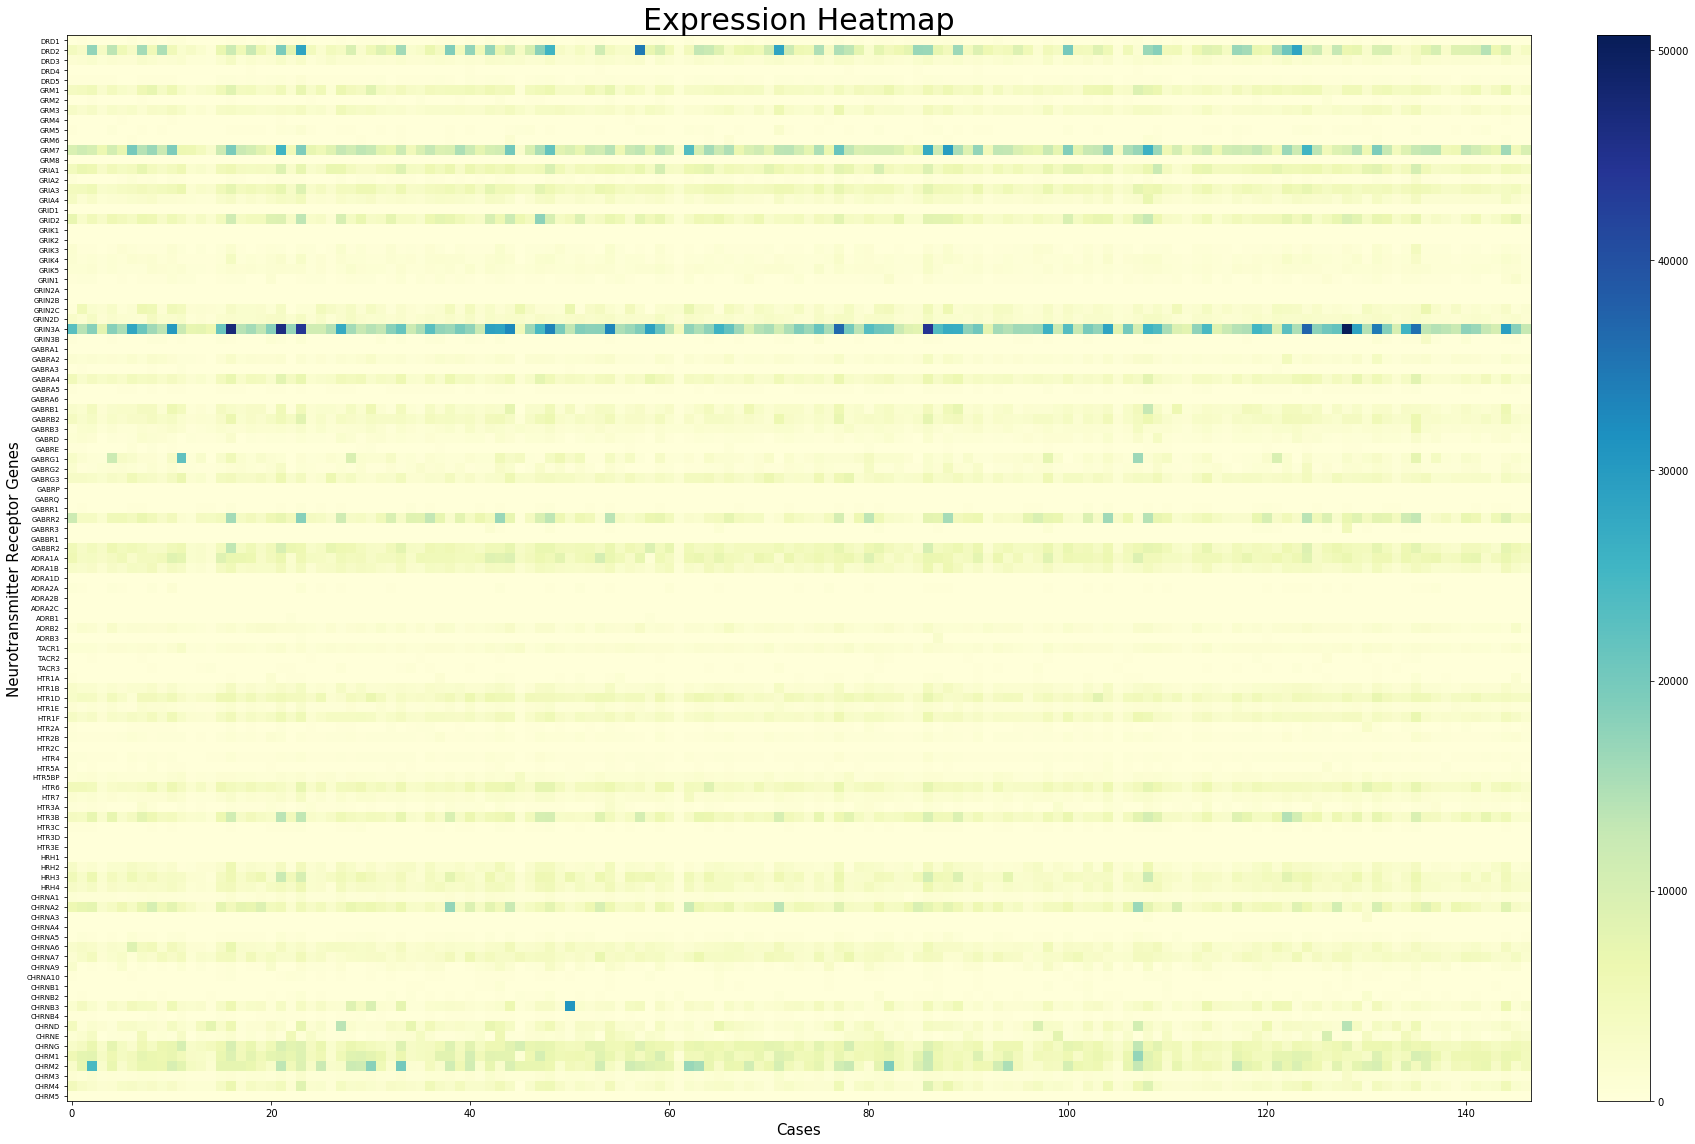

In [11]:
def draw_expression_heatmap(table, y_axis_list):
    # convert this dataframe made with the pandas library to an array that is usable with the numpy
    # library to create heatmap
    htseq_count_values = table.drop('hgnc_symbol', axis=1)
    expression_grid = htseq_count_values.to_numpy(copy=True, dtype=float)
    
    fig, ax = plt.subplots()
    # it's cmap='Blues_r' to change the color scheme
    im = ax.imshow(expression_grid, cmap='YlGnBu')
    
    # show labels for y axis
    ax.set_yticks(np.arange(len(y_axis_list)))
    ax.set_yticklabels(y_axis_list, fontsize=7)
    
    # set labels for axes
    ax.set_ylabel("Neurotransmitter Receptor Genes", fontsize=15)
    ax.set_xlabel("Cases", fontsize=15)
    
    # resizing the graph
    fig = plt.gcf()
    fig.set_size_inches(24, 16)
    
    
    fig.colorbar(im, fraction = 0.046, pad = 0.04)
    
    ax.set_title("Expression Heatmap", fontsize=30, ha='center')
    fig.tight_layout()
    plt.show()
    
    fig.savefig('image/expression_heatmap.png', dpi=100)
    
draw_expression_heatmap(rnaseq, receptor_gene_list)

## Part 1.b Logging the values on the Cancer Expression Heatmap



Here I'm trying out a natural log version of the values in this heatmap, to see if the results are better:



[[  147.   280.   160. ...   127.   115.   113.]
 [ 4112.  2811. 17294. ...  9665.  1771.  3394.]
 [ 1187.  1428.  1939. ...  2165.  1472.  1364.]
 ...
 [ 1073.   689.  1335. ...  1186.   538.   600.]
 [ 4702.  2886.  2049. ...  5239.  1790.  1448.]
 [    0.     0.     0. ...     0.     0.     0.]]
[[4.99043259 5.6347896  5.07517382 ... 4.84418709 4.74493213 4.72738782]
 [8.32166481 7.94129557 9.7581149  ... 9.17626639 7.47929964 8.12976445]
 [7.07918439 7.26403014 7.56992766 ... 7.68017564 7.2943773  7.21817684]
 ...
 [6.97821374 6.53524127 7.19668657 ... 7.07834158 6.28785856 6.39692966]
 [8.45574323 7.96762674 7.62510715 ... 8.56388592 7.4899709  7.27793857]
 [      -inf       -inf       -inf ...       -inf       -inf       -inf]]


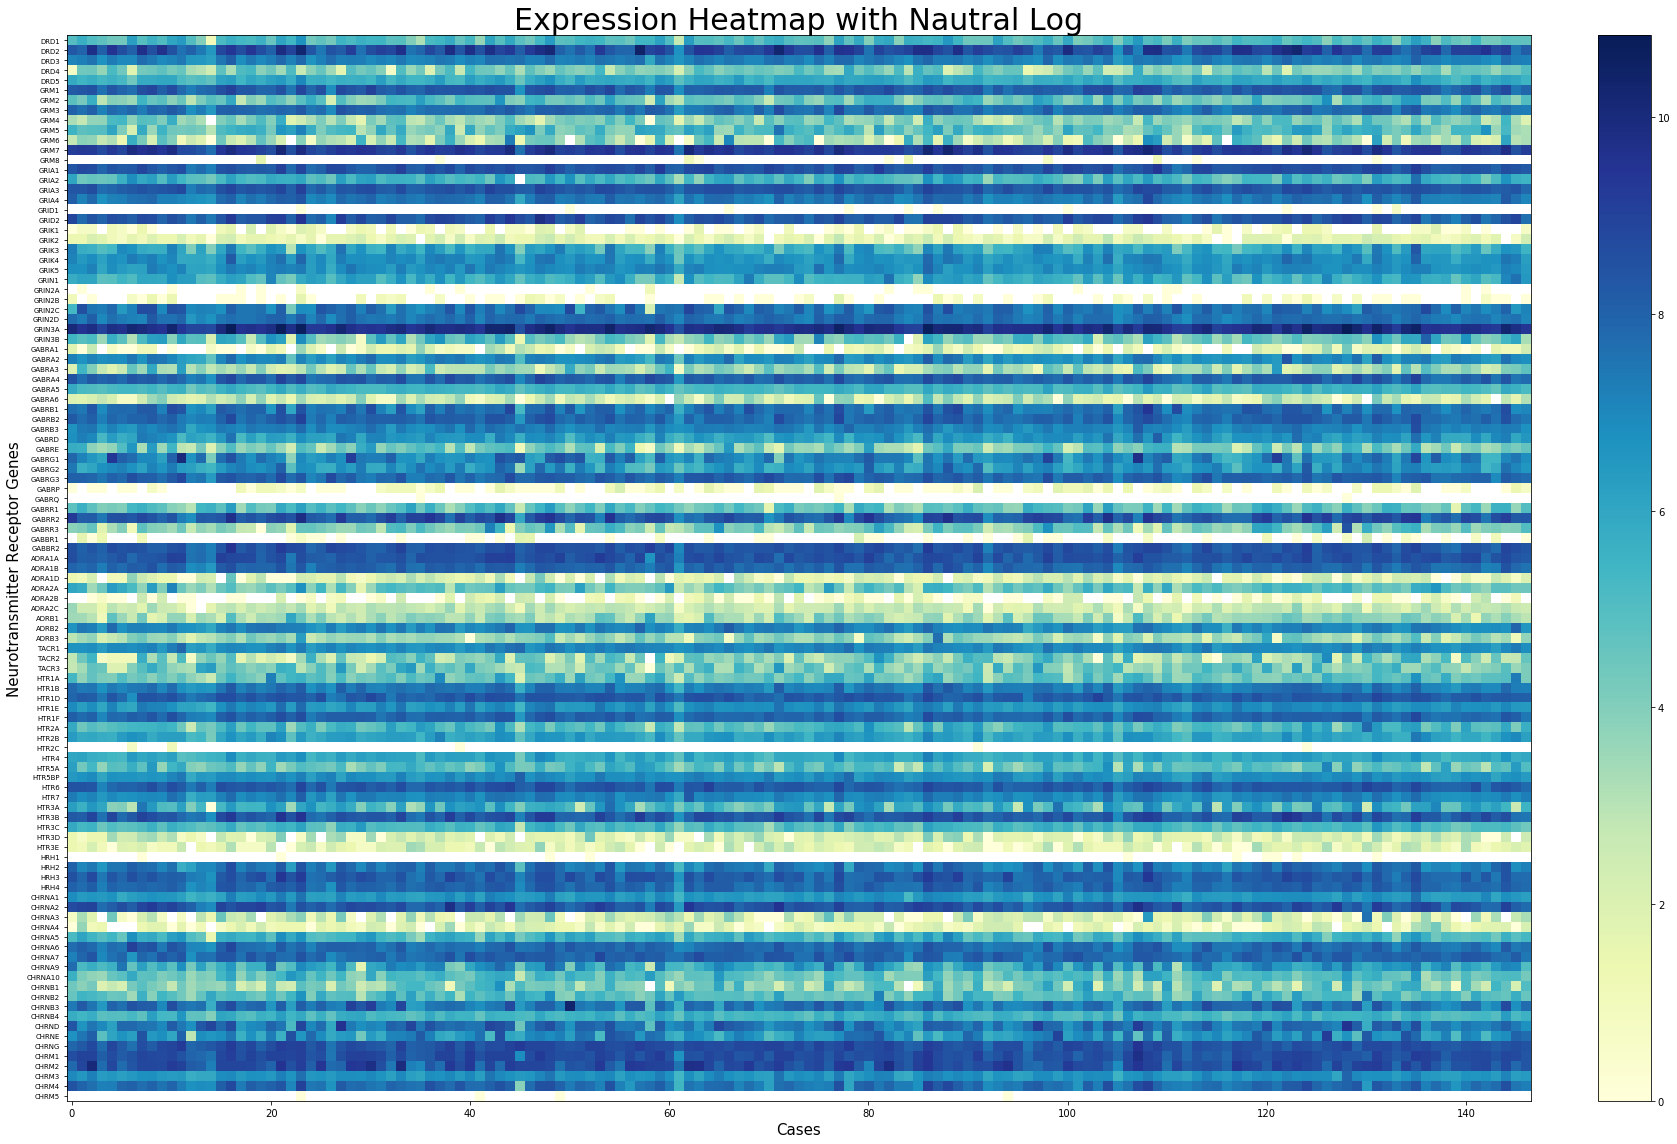

In [12]:
def draw_expression_log_heatmap():
    # convert this dataframe made with the pandas library to an array that is usable with the numpy
    # library to create heatmap
    htseq_count_values = rnaseq.drop('hgnc_symbol', axis=1)
    expression_grid = htseq_count_values.to_numpy(copy=True, dtype=float)
    
    print (expression_grid)
    np.seterr(divide = 'ignore')
    expression_logged = np.log(expression_grid)
    
    print(expression_logged)
    
    fig, ax = plt.subplots()
    # it's cmap='Blues_r' to change the color scheme
    im = ax.imshow(expression_logged, cmap='YlGnBu')
    
    # show labels for y axis
    ax.set_yticks(np.arange(len(receptor_gene_list)))
    ax.set_yticklabels(receptor_gene_list, fontsize=7)
    
    # set labels for axes
    ax.set_ylabel("Neurotransmitter Receptor Genes", fontsize=15)
    ax.set_xlabel("Cases", fontsize=15)
    
    # resizing the graph
    fig = plt.gcf()
    fig.set_size_inches(24, 16)
    
    
    fig.colorbar(im, fraction = 0.046, pad = 0.04)
    
    ax.set_title("Expression Heatmap with Nautral Log", fontsize=30, ha='center')
    fig.tight_layout()
    plt.show()
    
    fig.savefig('image/test.png', dpi=100)
    
draw_expression_log_heatmap()

## Part 1.c Reorganizing the data based on cumulative expression values



Going to try to reorganize the data based on:
Receptor genes (rows) by highest cumulative expression to lowest within each family
Cases (columns) by highest cumulative expression of all the cases


In [13]:
# changing the order of the receptor genes (rows):

rnaseq_columns = list(rnaseq.columns.values)

def sort_table(table):
    # creating a new table for sorting purposes
    rnaseq_with_total = table.copy()
    rnaseq_with_total.loc[:, 'Total by row'] = rnaseq_with_total.sum(axis=1)
    
    # sorting the rows
    rnaseq_sorted = pd.DataFrame(columns=rnaseq_columns)
    # sorts the rows section by section, based on the size of each family of neurotransmitters
    index_begin = 0
    index_end = 0
    appended_data = []
    for family, gene_list in neuro_genes_dict.items():
        index_end = len(gene_list) + index_begin
        to_sort = rnaseq_with_total[index_begin : index_end].sort_values('Total by row')
        appended_data.append(to_sort)
        index_begin = index_end
    # the families were sorted as separate dataframes and then concat together
    rnaseq_sorted = pd.concat(appended_data)
    
    # adding the column sum back in so now we can sort by column
    rnaseq_sorted_2 = rnaseq_sorted.to_numpy(copy=True)
    rnaseq_sorted = pd.DataFrame(rnaseq_sorted_2)
    
    rnaseq_columns.append('Total by row')
    rnaseq_sorted.columns = rnaseq_columns
    rnaseq_sorted.loc['Total by col', :] = rnaseq_with_total.sum(axis=0)
    rnaseq_columns.remove('Total by row')
    
    # sorting the columns:
    
    # remove hgnc_symbol column, sort the values, and then remove the total col and total row   
    excluded = rnaseq_sorted.loc[:, 'hgnc_symbol']
    del rnaseq_sorted['hgnc_symbol']
    sorted_cases = rnaseq_sorted.sort_values('Total by col', axis=1, ascending=True)
    rnaseq_sorted = pd.concat([excluded.rename('hgnc_symbol'), sorted_cases], axis=1)
    rnaseq_sorted.drop('Total by col', axis=0, inplace=True)
    rnaseq_sorted.drop('Total by row', axis=1, inplace=True)
    return rnaseq_sorted

sort_table(rnaseq)


,hgnc_symbol,X6423474d.60d7.4401.8e5b.46a3fbde5299.htseq.counts.gz,X0be94b2f.fccb.4482.b0ea.695c101aa65a.htseq.counts.gz,b6aa34d6.2b02.4317.8361.79536c7cb4e6.htseq.counts.gz,X09a677f2.d81d.4c3f.adf9.f8594e064e44.htseq.counts.gz,c19f102d.47a0.48c6.9443.63730d9ea6d1.htseq.counts.gz,X03094067.02d4.40c5.b6fa.bb5180dc7eab.htseq.counts.gz,X98b1beb5.8d4c.45d1.a618.2d43aafa056c.htseq.counts.gz,X0aac5e42.7554.4949.8b90.c16528c71ef8.htseq.counts.gz,X855d4a17.5c83.429d.919b.8c2a8e9bab0b.htseq.counts.gz,...,e38e0ced.093c.44e9.9f3b.7cdd0e6b912e.htseq.counts.gz,X44c3d518.14fa.4d63.b265.d7fc81c398e2.htseq.counts.gz,e7cc80ef.4b87.47d9.bebe.1fb05b5b04a2.htseq.counts.gz,X7bf647f0.c20e.42e6.b7d5.6510a8d066fc.htseq.counts.gz,X4929062b.3127.4038.8313.c20cbd274be4.htseq.counts.gz,b9ab7393.4abb.41ec.9d55.a3dc846c4a93.htseq.counts.gz,X16c63027.f745.41c4.a5e8.f6d9f1fbf1c8.htseq.counts.gz,X0f426284.c121.4860.bb80.8df032b0dea8.htseq.counts.gz,X1f2aa905.5022.4efe.afac.022d1acfdbe5.htseq.counts.gz,X8a799dfa.c1b5.4b13.9c91.6cbfe2abbc9f.htseq.counts.gz
0,DRD4,8,11,12,27,36,39,86,21,19,...,55,99,42,28,34,32,30,25,15,109
1,DRD1,15,3,54,152,59,116,88,55,300,...,276,384,545,462,582,145,432,284,784,211
2,DRD5,122,110,146,127,135,206,207,160,166,...,522,317,891,529,781,387,600,536,1102,643
3,DRD3,709,508,546,691,679,833,926,668,864,...,1851,1822,3031,2584,2477,1518,2597,3341,2503,2720
4,DRD2,814,677,753,2988,1607,3172,6131,1621,7557,...,9562,11122,3782,14711,25699,16597,19489,11817,28453,16498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,CHRNA7,2002,1963,1660,841,1642,1123,2245,2209,969,...,2752,3098,2646,3508,3872,4069,2272,4471,4763,4267
103,CHRNA2,599,996,2188,3047,2037,2225,3352,1435,6160,...,10085,12213,6459,8546,7875,7857,5260,4584,5089,7703
104,CHRNG,3526,4172,2261,2662,2449,2378,1970,3364,2785,...,6226,8213,5839,6367,7287,5934,9594,9809,8659,8961
105,CHRM1,749,1874,2547,2839,2545,3273,3235,2621,3696,...,9021,7885,10003,7063,6867,8481,8187,8961,8755,12527


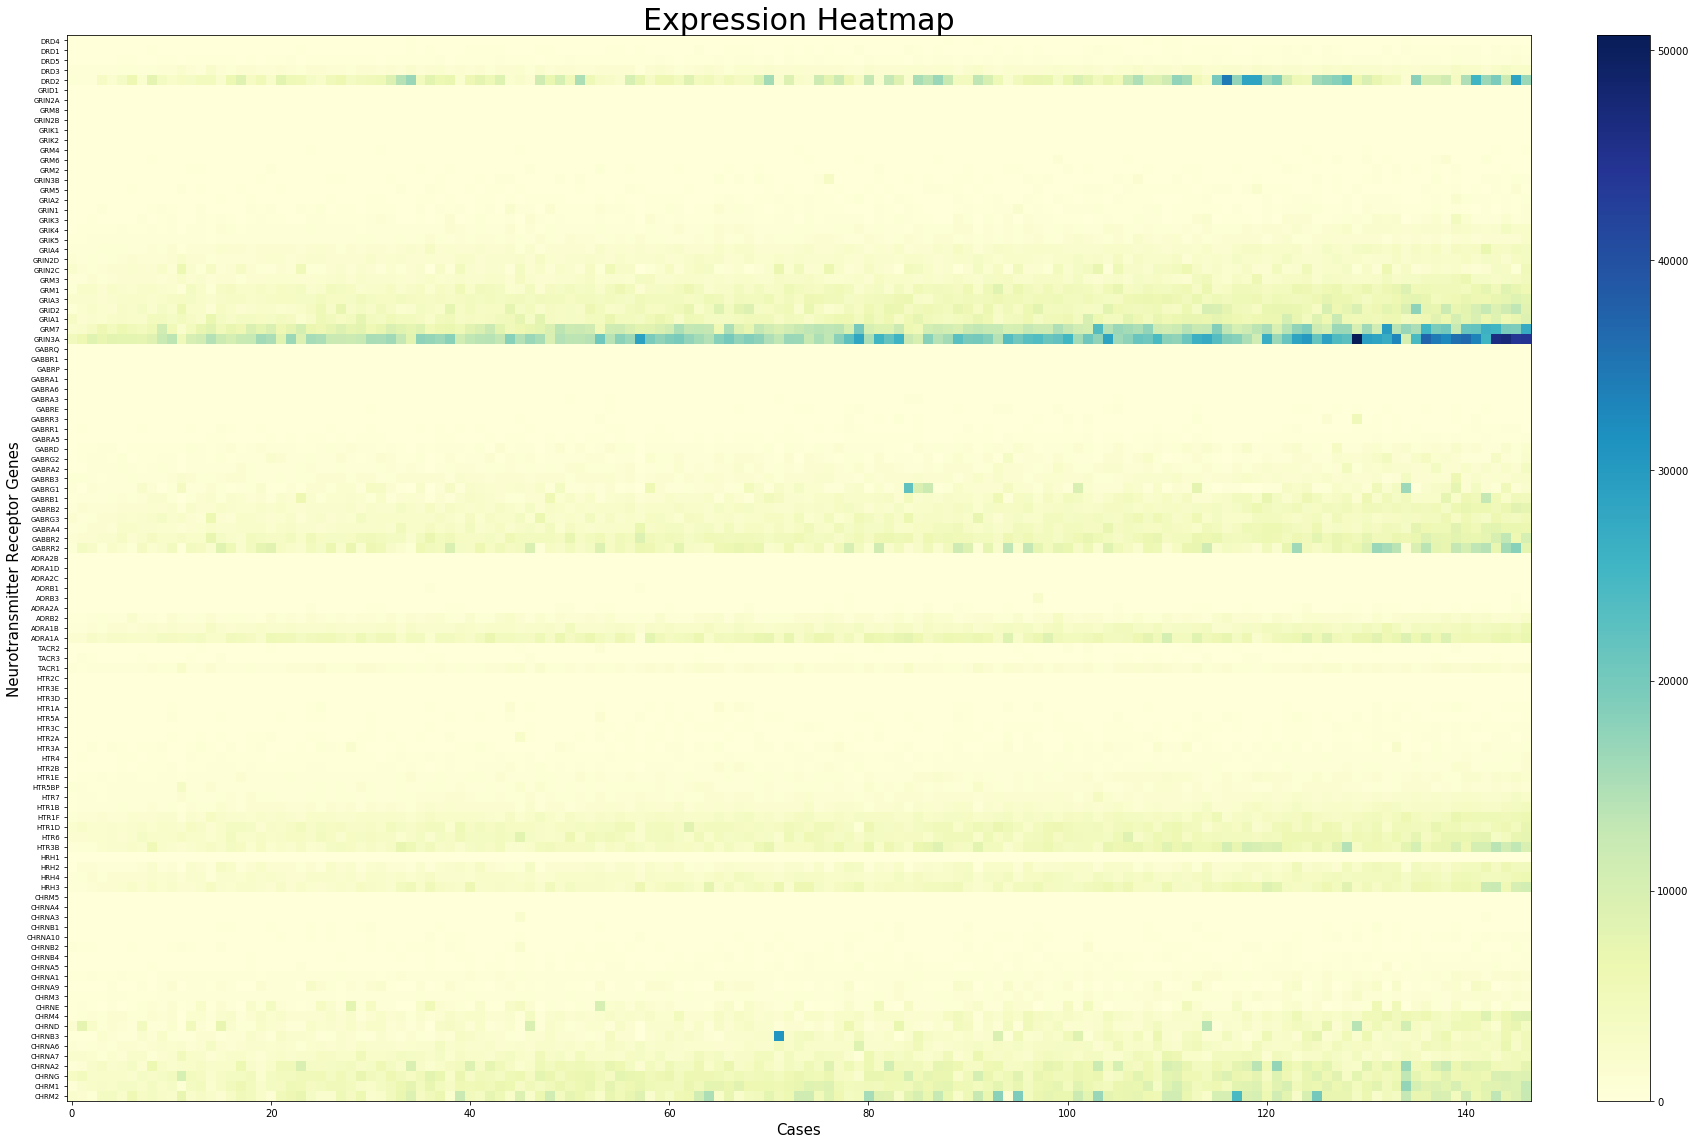

In [14]:
rnaseq_sorted = sort_table(rnaseq)
draw_expression_heatmap(rnaseq_sorted, rnaseq_sorted['hgnc_symbol'].tolist())

## Part 1.d Scaling the heatmap from Part 1.a

Scaling the data to be from 0 to 1 so it might be easier to visualize

In [15]:
def scale_data(table):
    scaled_table = table.copy()
    excluded = scaled_table.loc[:, 'hgnc_symbol']
    scaled_table.drop('hgnc_symbol', axis=1, inplace=True)
    max_value = scaled_table.max().max()
    
    scaled_table = scaled_table/max_value
    
    full_scaled_table = pd.concat([excluded.rename('hgnc_symbol'), scaled_table], axis=1)
    
    return full_scaled_table

scale_data(rnaseq)


,hgnc_symbol,X00faf8ba.ff90.4214.9d03.6c5e14645d8f.htseq.counts.gz,X0143419f.2abe.4906.bb55.af6010fab05f.htseq.counts.gz,X01f84c45.2058.4e22.b234.52f0a82a97fc.htseq.counts.gz,X03094067.02d4.40c5.b6fa.bb5180dc7eab.htseq.counts.gz,X0349f526.7816.4a7d.9967.1f75dd9ff00a.htseq.counts.gz,X03630a0c.aa97.4e28.bac9.0206fff669cd.htseq.counts.gz,X03761959.a620.440f.bbaa.33bd75afae1c.htseq.counts.gz,X057aa9ac.f22c.4c11.a44d.ad52ae59b4cf.htseq.counts.gz,X05f0ced5.6976.4f43.9be5.fddb3f550adf.htseq.counts.gz,...,eb3894d4.fcae.43ef.ad68.b756c6aa56ea.htseq.counts.gz,f144de50.6126.4912.9c94.824d1eb0fac5.htseq.counts.gz,f2389819.b8fc.460e.821c.01dba313cce1.htseq.counts.gz,f6bd7191.a820.4d86.927a.b4b5f88ebd67.htseq.counts.gz,f748bf78.4dc1.47ad.8611.8186479d3e4b.htseq.counts.gz,f8551a29.d4bd.4954.bf9c.8e10265063de.htseq.counts.gz,f9f63982.b0ee.4cb8.8de5.f885d82137f0.htseq.counts.gz,fcd43085.7338.43fe.bc25.9d87b04e227f.htseq.counts.gz,feb22766.4282.47c8.bfe2.7d020b4a15d4.htseq.counts.gz,fef65b57.c58d.4050.8de4.f09f5cd616ce.htseq.counts.gz
6402,DRD1,0.002899,0.005522,0.003156,0.002288,0.001578,0.001538,0.010137,0.002781,0.005207,...,0.000947,0.003412,0.001953,0.001479,0.004714,0.001538,0.001420,0.002505,0.002268,0.002229
6403,DRD2,0.081100,0.055441,0.341084,0.062560,0.269274,0.107883,0.060213,0.310376,0.103879,...,0.200363,0.050431,0.170365,0.175256,0.182198,0.277794,0.121906,0.190620,0.034929,0.066939
6404,DRD3,0.023411,0.028164,0.038242,0.016429,0.030669,0.021143,0.020452,0.045066,0.033312,...,0.029091,0.021794,0.026764,0.025363,0.026941,0.020038,0.015680,0.042700,0.029032,0.026902
6405,DRD4,0.000039,0.001558,0.001637,0.000769,0.003728,0.001558,0.000118,0.001459,0.001617,...,0.002544,0.000552,0.002485,0.001893,0.002012,0.001657,0.000749,0.001676,0.001440,0.003018
6406,DRD5,0.007041,0.004674,0.005917,0.004063,0.005088,0.003866,0.001598,0.006607,0.006627,...,0.007416,0.004852,0.003116,0.004339,0.009566,0.004911,0.006568,0.009822,0.007692,0.004852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4266,CHRM1,0.112124,0.150859,0.159478,0.064552,0.117311,0.071613,0.091572,0.146835,0.130268,...,0.132063,0.064197,0.113583,0.117567,0.125831,0.125989,0.090803,0.134509,0.123070,0.089423
4267,CHRM2,0.049524,0.144015,0.482220,0.045914,0.135140,0.044376,0.088732,0.135850,0.133858,...,0.079956,0.044514,0.094906,0.091277,0.123425,0.135416,0.060647,0.126245,0.050273,0.085991
4268,CHRM3,0.021162,0.013589,0.026330,0.011400,0.013589,0.009980,0.013254,0.016942,0.017750,...,0.012208,0.009901,0.009743,0.014970,0.014457,0.015186,0.010887,0.023391,0.010611,0.011834
4271,CHRM4,0.092736,0.056920,0.040412,0.026310,0.028243,0.052936,0.060923,0.043193,0.056486,...,0.044771,0.029071,0.014378,0.029308,0.050904,0.035166,0.044258,0.103327,0.035304,0.028558


### Plotting the scaled data, without reorganization from 1.c:

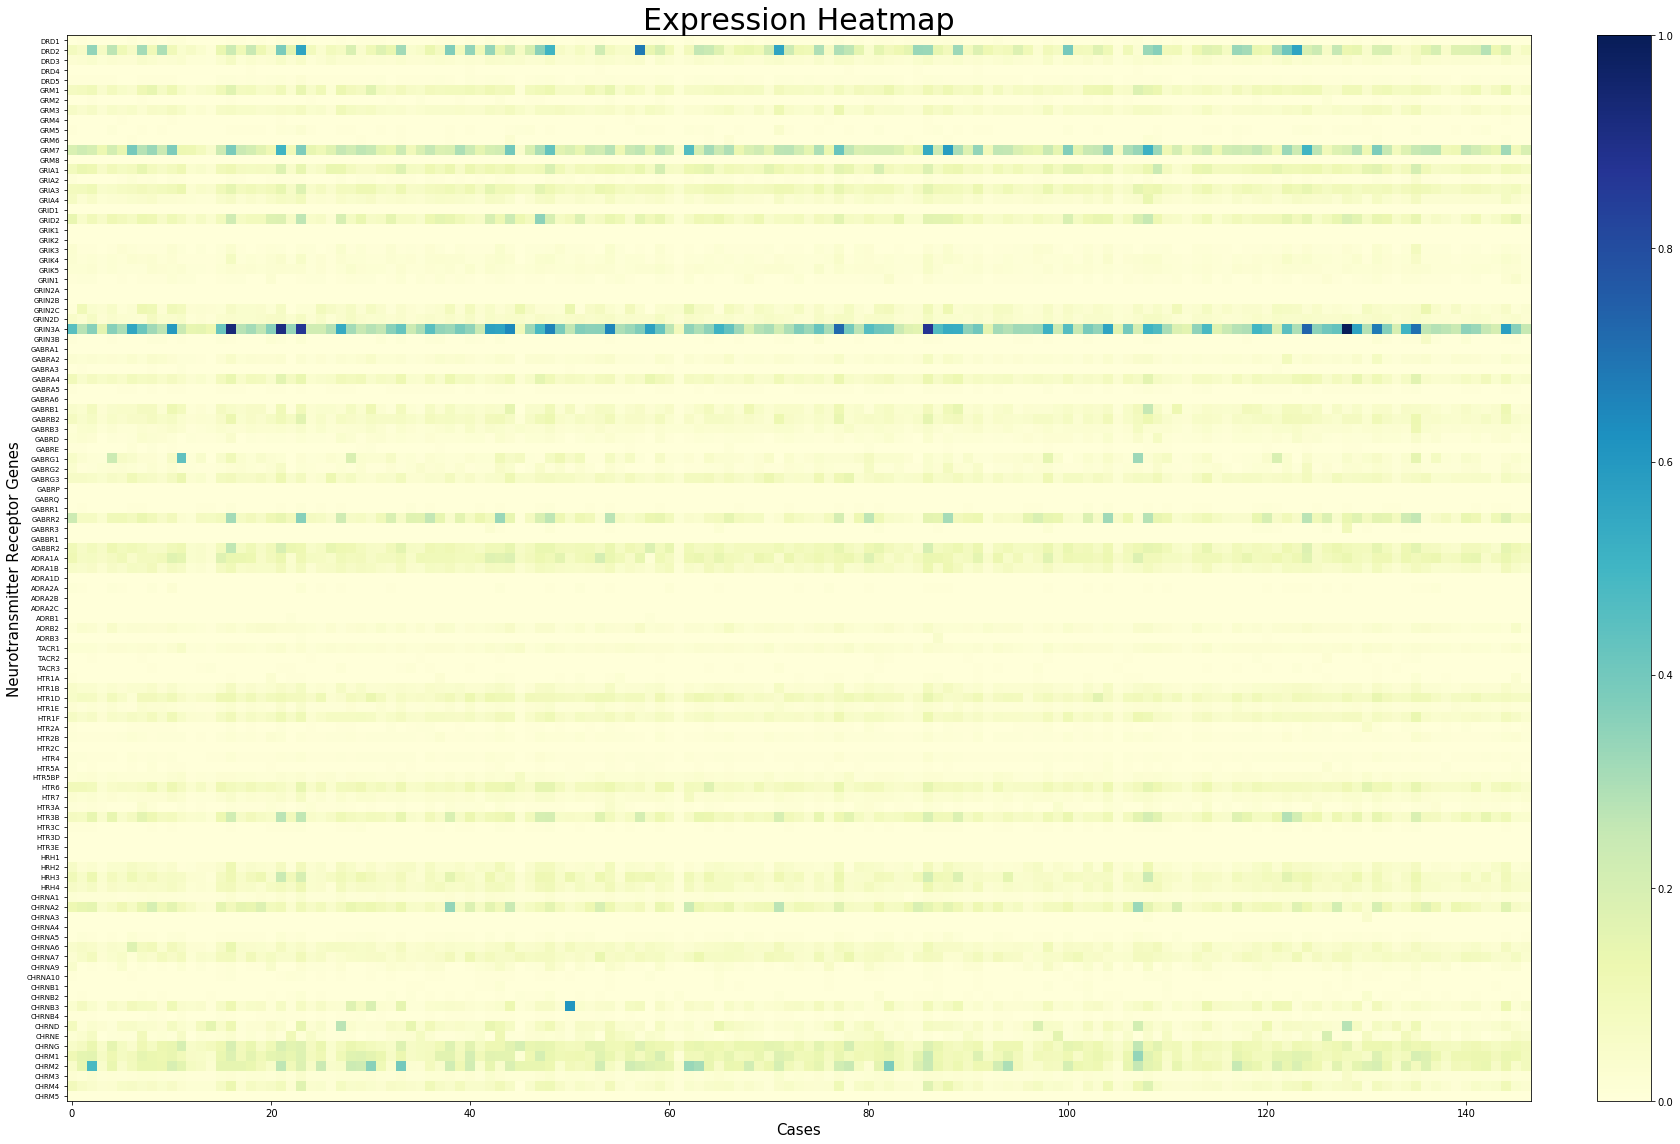

In [16]:
rnaseq_scaled = scale_data(rnaseq)
draw_expression_heatmap(rnaseq_scaled, rnaseq_scaled['hgnc_symbol'].tolist())

### Plotting the scaled data, with reorganization from 1.c:

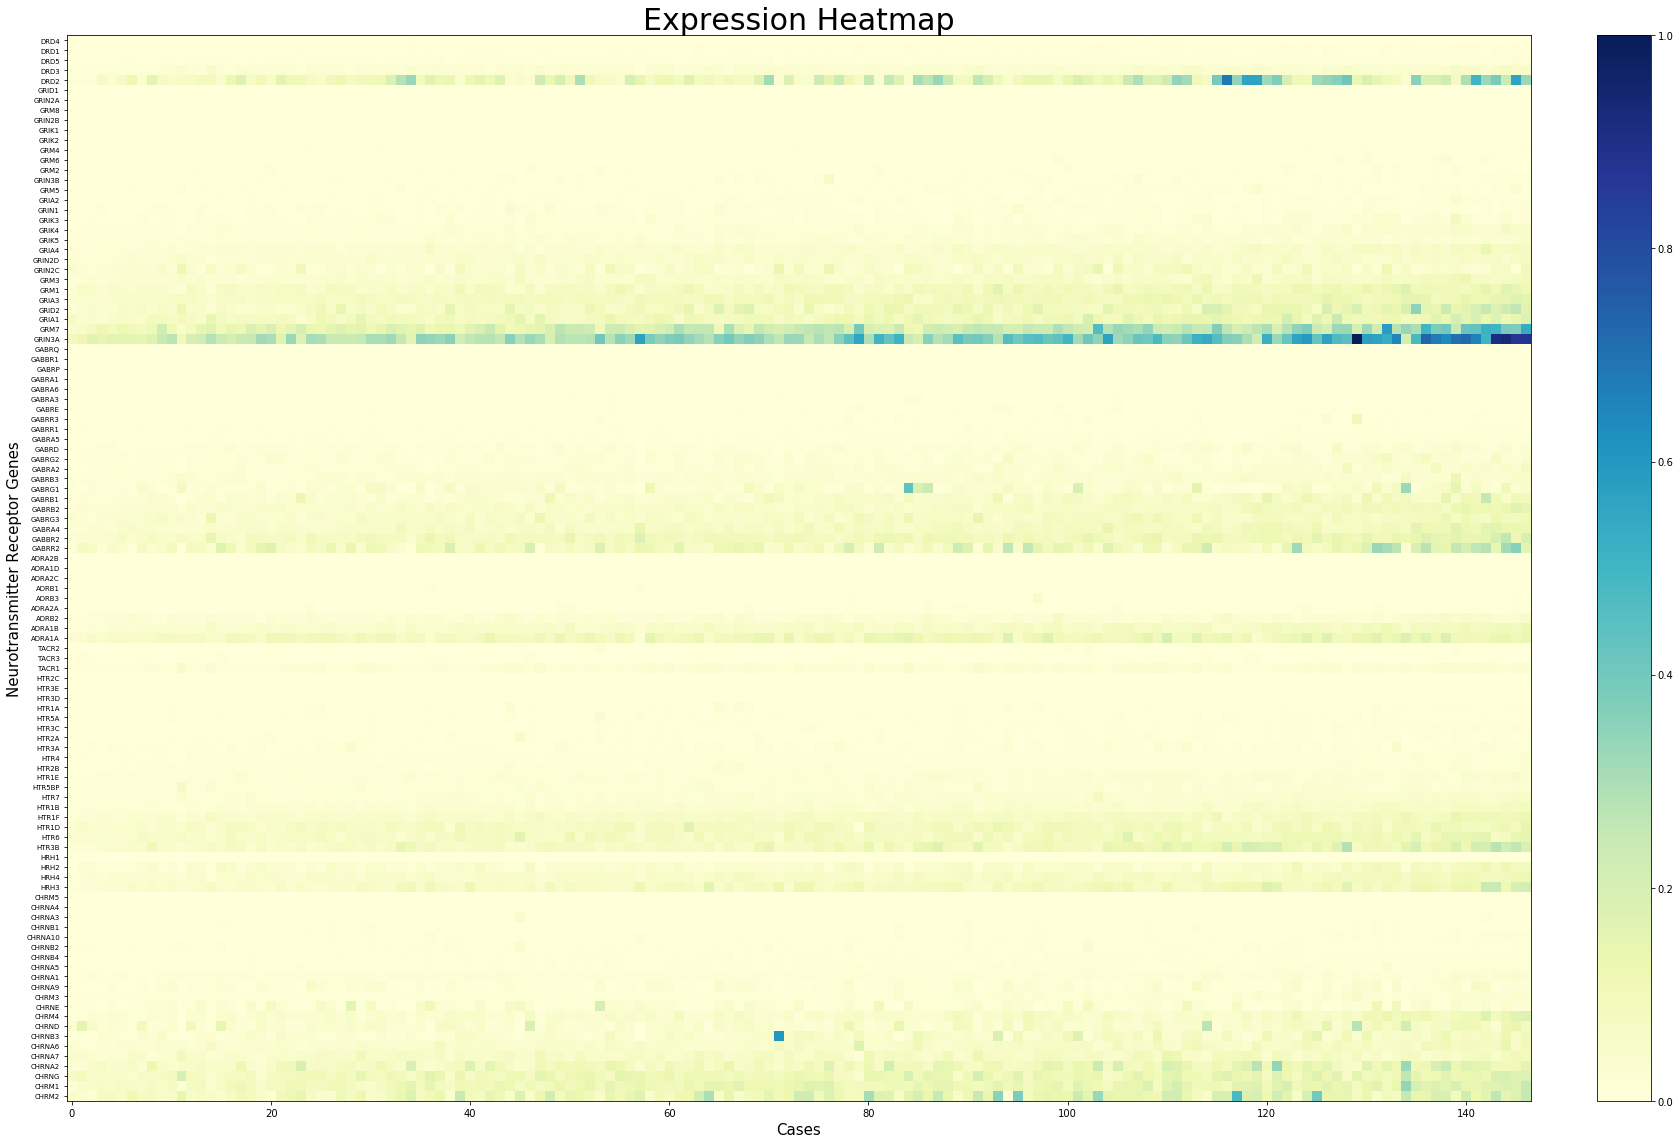

In [17]:
rnaseq_scaled_sorted = sort_table(rnaseq_scaled)
draw_expression_heatmap(rnaseq_scaled_sorted, rnaseq_scaled_sorted['hgnc_symbol'].tolist())






# Part 2: Gene Expression Heatmaps Based on TPM

In Part 2, we're looking to convert all the counts to Transcripts per Kb Million.

We are calculating the TPM with the calculate_tpm(table) function below but it basically entails:
1. normalize length by dividing read counts by the length of a gene in kb. read counts are the values of the index at (gene, sample)
2. normalize sequencing depth by finding the total read count per column (sample) and dividing by 1 million. 
3. take that per million scaling factor and do: normalized read count (from step 1)/scaling factor


We're using the PyEmsembl library to obtain transcript length of each gene. This can be downloaded with <pip install pyensembl>. This command had to be run afterwards: <pyensembl install --release 99 --species homo_sapiens>


In [18]:
import pyensembl
ensembl = pyensembl.EnsemblRelease()

PyEnsembl seems to be a little outdated without the full functionality of the Ensembl website and it seems that some gene names don't match to Ensembl Genes. 

For now, I'm just creating a dictionary of gene names that don't have any query results and providing the ensembl id to avoid errors. If this is a persistent problem, potential solutions without hooking up a database could be to write a quick web scraper for the search result of the gene name.

In [19]:
missing_genes_dict = {'C12orf74':'PLEKHG7',
                     'LINC00856':'LINC00595'}

precalculated_gene_length_dict = {'CCL3L1': 3.090}

I'm leaving my 1 million print statements in the calculate tpm function for now in case I need to come back and debug. I do think it is doing the calculations right.

In [20]:
# CALCULATING TPM

def calculate_rpk(sample_count, gene_length):
    reads_per_kilobase = sample_count / gene_length
    return reads_per_kilobase

def calculate_per_million(total_reads):
    return total_reads / 1000000



def calculate_tpm2(table):
    # set up the dataframe for conversions
    working_table = table.copy()
    #excluded = tpm_table.loc[:, 'hgnc_symbol']
    #tpm_table.drop('hgnc_symbol', axis=1, inplace=True)
    
    
    gene_search = ensembl.genes_by_name('DRD1')
    print(gene_search[0].start)
    tpm_table_as_list = []
    for index, row in working_table.iterrows():
        gene_length = 0
        for column_name, count in row.iteritems():
            if column_name == 'hgnc_symbol':
                gene_search = ensembl.genes_by_name(count)
                gene_length = gene_search[0].end - gene_search[0].start
                # clear the gene search cache
                gene_search = None
            
def find_gene_length_ensembl(gene_name):
    gene_search = ensembl.genes_by_name(gene_name)
    gene_length = (gene_search[0].end - gene_search[0].start) / 1000
    # clear the gene search cache
    gene_search = None
    return gene_length


def calculate_tpm(table):

    # converting this to numpy array so it's easier to work with
    # doing this loses the indexing that the original rnaseq table has but 
    # can be added back in later
    table_numpy = table.to_numpy(copy=True)
    
    
    ## -------- FOR CALCULATING RPK ----------
    rpk_table = table_numpy
    gene_length = 0
    
    #print (table_numpy)
    
    # index is a tuple of row, col
    # index[0] = row
    # index[1] = column
    for index, value in np.ndenumerate(table_numpy):
        #print ("its me, the value:")
        #print (value)
        # if column is the first column ('hgnc_symbol') column
        
        # in column 0, value refers to the gene name. 
        # in the rest of the columns, it refers to the read count
        if index[1] == 0:
            gene = value
            #print (gene)
            if gene in precalculated_gene_length_dict:
                gene_length = precalculated_gene_length_dict.get(value)
            else:
                if gene in missing_genes_dict:
                    gene = missing_genes_dict.get(value)
                gene_length = find_gene_length_ensembl(gene)
            
            #print ("i'm setting the gene_length")
            #print (gene_length)
                
        else:
            #print ("now i'm doing math")
            #print (gene_length)
            #print (rpk_table[index[0], index[1]])
            rpk_table[index[0], index[1]] = calculate_rpk(value, gene_length)
            #print (rpk_table[index[0], index[1]])
    
    #print (rpk_table)
    
    ## ---- FOR CALCULATING PER MILLION SCALING FACTOR -----
    per_mil_table = rpk_table
    
    total_reads = np.sum(rpk_table[:, 1:], axis=0)
    
    #print (total_reads)
    
    for index, value in np.ndenumerate(rpk_table):
        #print ("i'm the value")
        #print (value)
        if (index[1] == 0):
            continue
        total_for_column = total_reads[index[1] - 1]
        #print ("i'm the index")
        #print (index)
        #print ("i'm the total reads")
        #print (total_reads[index[1] - 1])
        #print (index[1] - 1)
        #print ("i'm the scaling factor")
        
        scaling_factor = calculate_per_million(total_for_column)
        
        #print (scaling_factor)
        #print (total_for_column / 1000000)
        #print ("i'm per mil value")
        #print (per_mil_table[index[0], index[1]])
        
        # this value references the rpk_table
        per_mil_table[index[0], index[1]] = value / scaling_factor
        #print (per_mil_table[index[0], index[1]])
    
    #print (per_mil_table)
    tpm_table = pd.DataFrame(per_mil_table, columns=rnaseq_columns)
    
    return tpm_table

In [21]:
tpm_all_rnaseq_selected_samples = calculate_tpm(all_rnaseq_selected_samples)

tpm_all_rnaseq_selected_samples

,hgnc_symbol,X00faf8ba.ff90.4214.9d03.6c5e14645d8f.htseq.counts.gz,X0143419f.2abe.4906.bb55.af6010fab05f.htseq.counts.gz,X01f84c45.2058.4e22.b234.52f0a82a97fc.htseq.counts.gz,X03094067.02d4.40c5.b6fa.bb5180dc7eab.htseq.counts.gz,X0349f526.7816.4a7d.9967.1f75dd9ff00a.htseq.counts.gz,X03630a0c.aa97.4e28.bac9.0206fff669cd.htseq.counts.gz,X03761959.a620.440f.bbaa.33bd75afae1c.htseq.counts.gz,X057aa9ac.f22c.4c11.a44d.ad52ae59b4cf.htseq.counts.gz,X05f0ced5.6976.4f43.9be5.fddb3f550adf.htseq.counts.gz,...,eb3894d4.fcae.43ef.ad68.b756c6aa56ea.htseq.counts.gz,f144de50.6126.4912.9c94.824d1eb0fac5.htseq.counts.gz,f2389819.b8fc.460e.821c.01dba313cce1.htseq.counts.gz,f6bd7191.a820.4d86.927a.b4b5f88ebd67.htseq.counts.gz,f748bf78.4dc1.47ad.8611.8186479d3e4b.htseq.counts.gz,f8551a29.d4bd.4954.bf9c.8e10265063de.htseq.counts.gz,f9f63982.b0ee.4cb8.8de5.f885d82137f0.htseq.counts.gz,fcd43085.7338.43fe.bc25.9d87b04e227f.htseq.counts.gz,feb22766.4282.47c8.bfe2.7d020b4a15d4.htseq.counts.gz,fef65b57.c58d.4050.8de4.f09f5cd616ce.htseq.counts.gz
0,A1BG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A1BG-AS1,0,0.00319353,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A1CF,2.30977,1.00018,0.938172,2.92684,1.54392,2.05069,3.47259,2.02943,1.80303,...,1.84098,1.08573,1.21983,2.60587,1.39173,0.914085,2.11719,1.70303,1.02618,1.36662
3,A2M,0.0213861,0.0422278,0.0499898,0.0867455,0.0402301,0.0340714,0.0820388,0.100178,0.0754061,...,0.137374,0.033416,0.0550142,0.0521968,0.0288277,0.0524673,0.142909,0.0537884,0.00778586,0.0871956
4,A2M-AS1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37333,ZYG11AP1,1.08617,0.223943,0.951985,0.754221,0.87783,0.0490101,0.0581493,0.785407,2.49183,...,0.682356,0.23347,0.230623,0.510561,0.920743,0.957988,6.03287,1.80248,0.179193,0.938191
37334,ZYG11B,0.712352,0.699739,1.14639,1.63047,1.63098,1.13945,0.901481,1.56126,1.22244,...,1.46988,0.791683,1.11308,1.50363,0.856166,1.39928,1.22602,0.6881,0.798788,1.1812
37335,ZYX,6.27933,2.84438,3.22181,8.71705,1.71174,24.2591,79.0368,7.03347,11.5098,...,8.1347,9.79758,2.88127,11.3215,5.06178,11.9651,10.241,6.30556,3.14511,4.73681
37336,ZYXP1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.290379,0,0,0,0


In [33]:
# only select our genes of interest
rnaseq_tpm = filter_genes_of_interest(tpm_all_rnaseq_selected_samples)

# sort genes of interest
rnaseq_tpm = sort_genes_of_interest(rnaseq_tpm)

rnaseq_tpm

,hgnc_symbol,X00faf8ba.ff90.4214.9d03.6c5e14645d8f.htseq.counts.gz,X0143419f.2abe.4906.bb55.af6010fab05f.htseq.counts.gz,X01f84c45.2058.4e22.b234.52f0a82a97fc.htseq.counts.gz,X03094067.02d4.40c5.b6fa.bb5180dc7eab.htseq.counts.gz,X0349f526.7816.4a7d.9967.1f75dd9ff00a.htseq.counts.gz,X03630a0c.aa97.4e28.bac9.0206fff669cd.htseq.counts.gz,X03761959.a620.440f.bbaa.33bd75afae1c.htseq.counts.gz,X057aa9ac.f22c.4c11.a44d.ad52ae59b4cf.htseq.counts.gz,X05f0ced5.6976.4f43.9be5.fddb3f550adf.htseq.counts.gz,...,eb3894d4.fcae.43ef.ad68.b756c6aa56ea.htseq.counts.gz,f144de50.6126.4912.9c94.824d1eb0fac5.htseq.counts.gz,f2389819.b8fc.460e.821c.01dba313cce1.htseq.counts.gz,f6bd7191.a820.4d86.927a.b4b5f88ebd67.htseq.counts.gz,f748bf78.4dc1.47ad.8611.8186479d3e4b.htseq.counts.gz,f8551a29.d4bd.4954.bf9c.8e10265063de.htseq.counts.gz,f9f63982.b0ee.4cb8.8de5.f885d82137f0.htseq.counts.gz,fcd43085.7338.43fe.bc25.9d87b04e227f.htseq.counts.gz,feb22766.4282.47c8.bfe2.7d020b4a15d4.htseq.counts.gz,fef65b57.c58d.4050.8de4.f09f5cd616ce.htseq.counts.gz
517,DRD1,1.85972,0.696484,0.649976,2.17918,0.958807,2.06265,1.23358,1.26915,1.70903,...,2.85704,1.24129,1.38571,2.89226,1.73717,0.679898,2.89827,1.34248,0.822084,1.35363
518,DRD2,1.02114,0.522637,0.552979,1.25943,0.842436,1.00326,1.91953,1.11142,2.10043,...,0.878898,0.646541,0.742625,1.21049,0.758954,0.403227,0.994331,1.02525,0.534566,0.749378
519,DRD3,0.00557585,0.00258663,0.00674743,0,0.00314668,0.00509478,0.0846277,0.0168476,0.0120883,...,0.00181881,0,0.00133189,0.0123841,0.00199406,0.0023711,0.0382402,0.0059082,0.00155232,0.0103439
520,DRD4,4.09975,2.07708,0.177284,2.12438,4.47229,4.35468,2.75459,0.411799,7.12073,...,9.5023,1.71376,0.836588,1.46422,0.456795,0.359192,2.37368,0.804581,0.470313,0.928173
521,DRD5,0,0,0.0058145,0.0506726,0.00813481,0.013171,0,0.130663,0.0133932,...,0.126954,0.0209143,0.0103297,0,0.0773256,0.174699,0,0.00654596,0.0180588,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,CHRM1,11.8542,7.3276,5.94694,7.25507,4.66441,9.05834,10.3312,8.21659,16.823,...,9.47782,6.38264,6.40681,9.52787,9.6435,3.48801,18.229,7.47671,5.13658,6.23448
10959,CHRM2,0.519374,0.205945,0.233145,0.535912,0.27541,0.315545,0.412811,0.321274,0.464835,...,0.417538,0.260746,0.241286,0.372836,0.272273,0.267526,0.627627,0.3153,0.171539,0.521312
32875,CHRM3,0.208794,0.131245,0.131807,0.351089,0.213667,0.352307,0.345947,0.269579,0.437464,...,0.274132,0.206757,0.160097,0.337866,0.176034,0.190008,0.245818,0.170038,0.233095,0.256198
32876,CHRM4,0.0521779,0.161369,0.379673,0.0143861,0.00692849,0.0112179,0.0133098,0.88459,0.0950591,...,0.176208,0.549232,0.00586525,0.650533,0.109765,0.0287144,0.522033,0.0260179,0.0273437,0.322113


Plotting the resultant TPM tumor table:

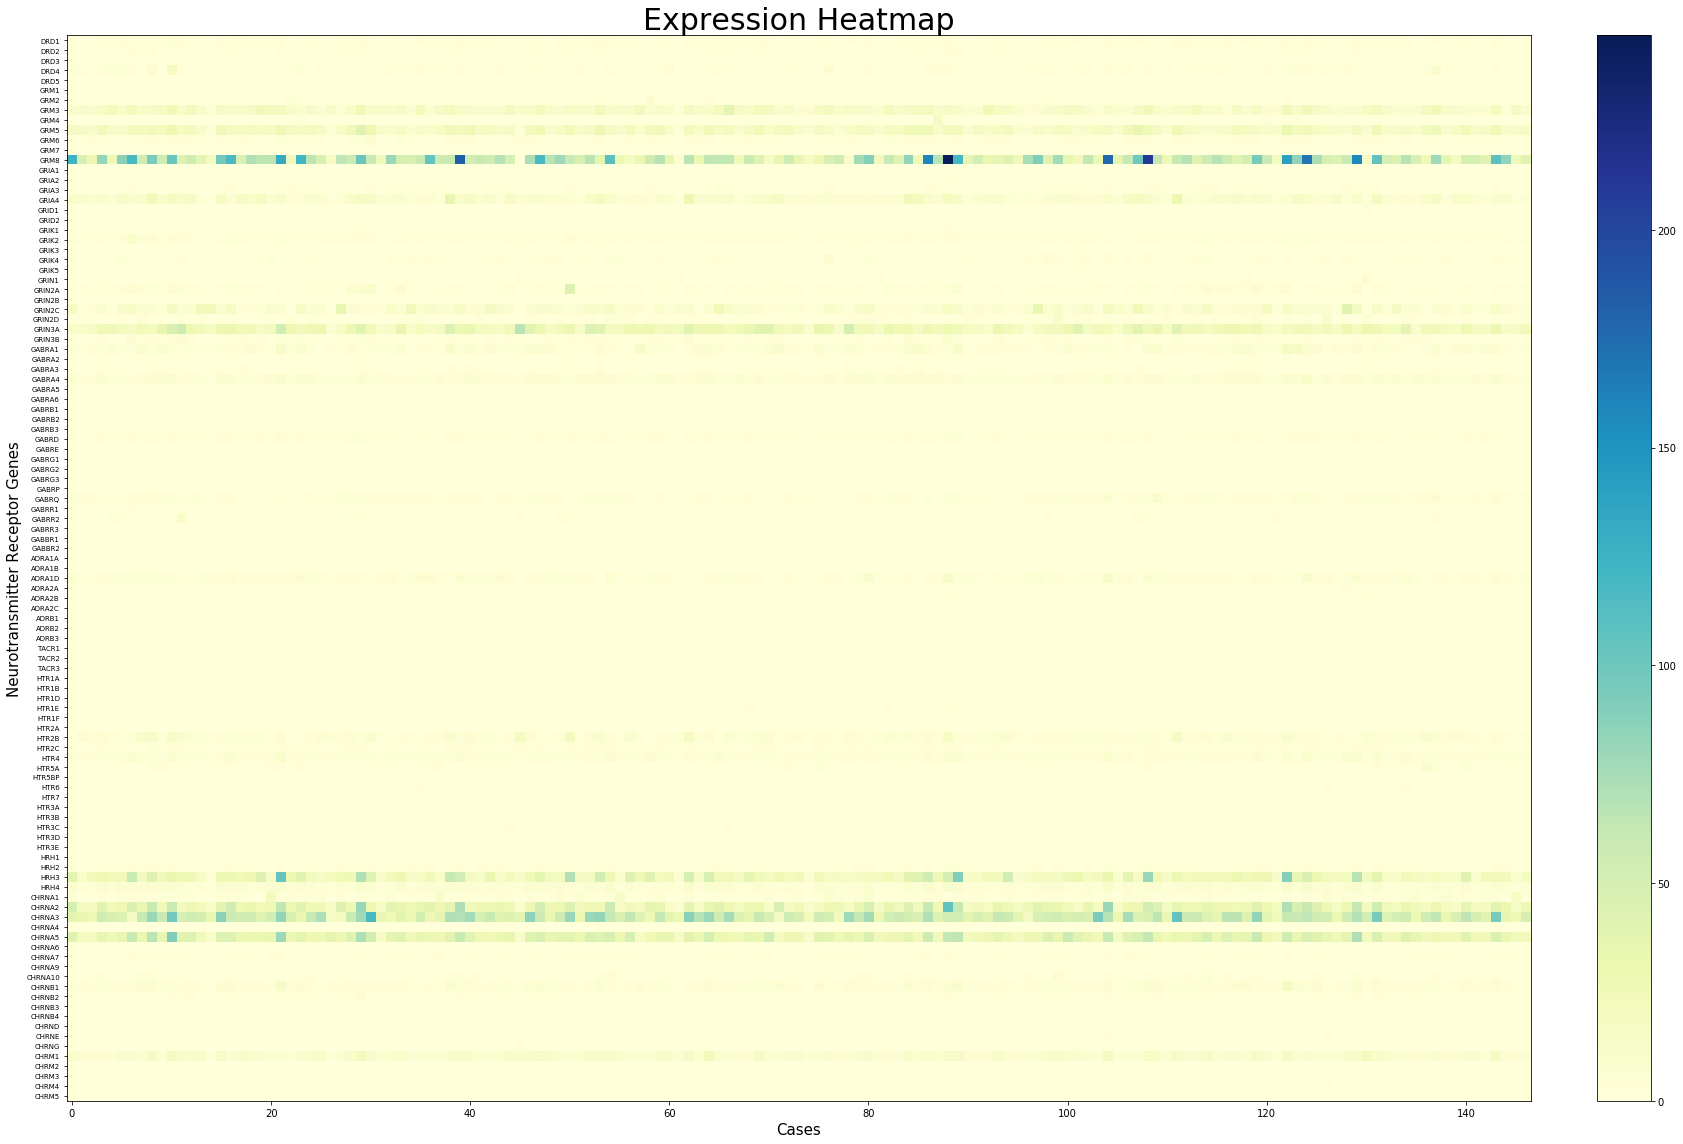

In [34]:
draw_expression_heatmap(rnaseq_tpm, rnaseq_tpm['hgnc_symbol'].tolist())

# Part 3: Gene Expression Heatmap with Neurotransmitter Families in Patients with Pancreatic Cancer

In this part, we will group the receptor genes by the neurotransmitter they correspond to and show the expression levels of the neurtransmitter families against our patient cohort.

In [ ]:
# we're starting off by adding the expression levels of each of the individual genes for each 
# family

# creating a new dataframe to store values per family
def add_expression_by_family():
    data = []
    for case in rnaseq_columns:
        case_dict = []
        for family, gene_list in neuro_genes_dict.items():
            value = 0
            if (case == 'hgnc_symbol'):
                case_dict.append(family)
                continue
            for gene in gene_list:
                value = rnaseq.loc[rnaseq.hgnc_symbol == gene, case].values[0] + value
            case_dict.append(float(value))     
        data.append(case_dict)
    return data


    

In [ ]:
expression_by_family = pd.DataFrame(add_expression_by_family())
expression_by_family = expression_by_family.transpose()
expression_by_family.columns = rnaseq_columns

expression_by_family

In [ ]:
def draw_expression_by_family():

    # convert the pandas dataframe to a numpy array
    htseq_count_by_family = expression_by_family.drop('hgnc_symbol', axis=1)
    expression_grid_by_family = htseq_count_by_family.to_numpy(copy=True, dtype=float)

    fig, ax = plt.subplots()
    im = ax.imshow(expression_grid_by_family, cmap="YlGnBu")

    # show labels for y axis
    ax.set_yticks(np.arange(len(neuro_genes_dict.keys())))
    ax.set_yticklabels(neuro_genes_dict.keys(), fontsize=8)

    # set labels for axes
    ax.set_ylabel("Neurotransmitter Receptor Genes By Family", fontsize=15)
    ax.set_xlabel("Cases", fontsize=15)
    
    # resizing the graph
    fig = plt.gcf()
    fig.set_size_inches(24, 16)


    fig.colorbar(im, fraction = 0.046, pad = 0.04, orientation = 'horizontal')

    ax.set_title("Expression Heatmap By Family", fontsize=30, ha='center')
    fig.tight_layout()
    plt.show()

    #fig_by_family.savefig('image/byfamily.png', dpi=100)
    
    
draw_expression_by_family()